In [1]:
# %load ../uoicorr_imports.py
# %load uoicorr_imports.py
%load_ext autoreload
%autoreload 2

import h5py

import numpy as np
import matplotlib.pyplot as plt

import sys, os, pdb

# Hack to import pyuoi
parent_path, current_dir = os.path.split(os.path.abspath('.'))
while current_dir not in ['nse']:
    parent_path, current_dir = os.path.split(parent_path)
    print(parent_path)
p = os.path.join(parent_path, current_dir)
# Add analysis
if p not in sys.path:
    sys.path.append(p)

import subprocess
hname = subprocess.check_output('hostname')

if 'ankitnse'.encode() in hname:

    if '%s/uoicorr' % p not in sys.path:
        sys.path.append('%s/uoicorr' % p)
    if '%s/PyUoI' % p not in sys.path:
        sys.path.append('%s/PyUoI' % p)

elif os.name == 'posix':

    pass

else:
    # And standard list of subdirectories
    if '%s\\pyuoi' % p not in sys.path:
        sys.path.append('%s\\pyuoi' % p)
    if '%s\\uoicorr' % p not in sys.path:
        sys.path.append('%s\\uoicorr' % p)

from postprocess import postprocess_file, postprocess_dir
from utils import FNR, FPR, selection_accuracy

/home/akumar/nse
/home/akumar


### Test whether sklearn's built-in covariance estimation methods work for our purposes

In [2]:
from utils import gen_covariance, gen_beta, gen_data, interpolate_covariance, gen_beta2

In [3]:
import itertools, time

In [4]:
from sklearn.covariance import EmpiricalCovariance, GraphicalLassoCV, LedoitWolf, MinCovDet, OAS, ShrunkCovariance

In [19]:
sparsity

array([0.1023293 , 0.18092559, 0.31988951, 0.56558776, 1.        ])

In [7]:
# Exhaustively generate all types of covariance matrices
n_samples = [100,  1000, 5000]
n_features = 1000
block_size = [1,  20, 100]
block_correlation = [0, 0.1,  0.5, 0.8]
L = [10, 100]
sparsity = np.logspace(0.01, 1, 5)/10
betawidth = 5

shape = ((len(n_samples), len(block_size), len(block_correlation), len(L), len(sparsity), 3))

methods = ['empirical', 'ShrunkCovariance', 'LedoitWolf', 'OAS', 'GraphicalLasso', 'MinCovDet']

estimates = {method : [] for method in methods}

estimated_cov = np.empty(shape, dtype = np.object)
estimated_cov.fill(estimates)
# Errors between estimated and actual covariance matrix (Frobenius Norm)
errors = np.zeros(shape + (len(methods),))

iter_idx = list(itertools.product(*[np.arange(length) for length in shape[:-1]]))

# Estimators
empcov = EmpiricalCovariance(assume_centered = True)
glcv = GraphicalLassoCV(cv = 5, assume_centered = True)
shrunk = ShrunkCovariance(assume_centered = True)
lw = LedoitWolf(assume_centered = True)
oas = OAS(assume_centered = True)
#mincovdet = MinCovDet(assume_centered = True, support_fraction = 0.75)

for ii, idx in enumerate(iter_idx):
    print(ii)
    ns = n_samples[idx[0]]
    nf = n_features
    bs = block_size[idx[1]]
    bc = block_correlation[idx[2]]
    l = L[idx[3]]
    s = sparsity[idx[4]]
    
    beta = gen_beta2(nf, bs, s, betawidth)
    sigmas = interpolate_covariance('block_covariance', 'exp_falloff', interp_coeffs = np.array([0, 0.5, 1]),
                                    n_features = nf, cov_type1_args = {'block_size': bs, 'correlation': bc},
                                   cov_type2_args = {'L' : l})

    for i, sigma in enumerate(sigmas):
        X, X_test, y, y_test = gen_data(n_samples = ns, n_features = nf,
                                       covariance = sigma['sigma'], beta = beta)
        
        empcov.fit(X)
        errors[idx + (i, 0)] = empcov.error_norm(sigma['sigma'])
#        t2 = time.time()
#        glcv.fit(X)
#        errors[idx + (i, 1)] = glcv.error_norm(sigma['sigma'])
#        print('Graphical Lasso: %f' % (time.time() - t2))
        shrunk.fit(X)
        errors[idx + (i, 2)] = shrunk.error_norm(sigma['sigma'])
        lw.fit(X)
        errors[idx + (i, 3)] = lw.error_norm(sigma['sigma'])
        oas.fit(X)
        errors[idx + (i, 4)] = oas.error_norm(sigma['sigma'])
#         mincovdet.fit(X)
#         errors[idx + (i, 5)] = mincovdet.error_norm(sigma['sigma'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
errors.size

6480

In [9]:
errors.shape

(3, 3, 4, 2, 5, 3, 6)

(array([797.,  53.,  70.,  25.,  66.,  38.,  22.,   7.,   1.,   1.]),
 array([3.87560337e-09, 1.68874327e+00, 3.37748653e+00, 5.06622980e+00,
        6.75497307e+00, 8.44371633e+00, 1.01324596e+01, 1.18212029e+01,
        1.35099461e+01, 1.51986894e+01, 1.68874327e+01]),
 <a list of 10 Patch objects>)

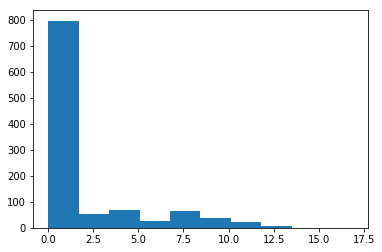

In [18]:
plt.hist(errors[...,4].ravel())

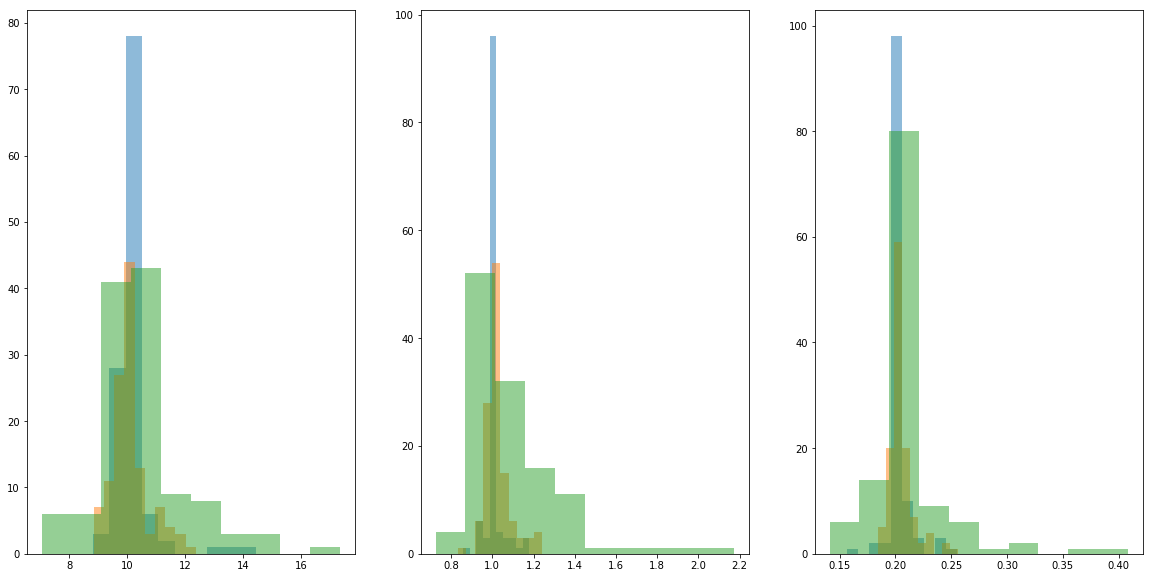

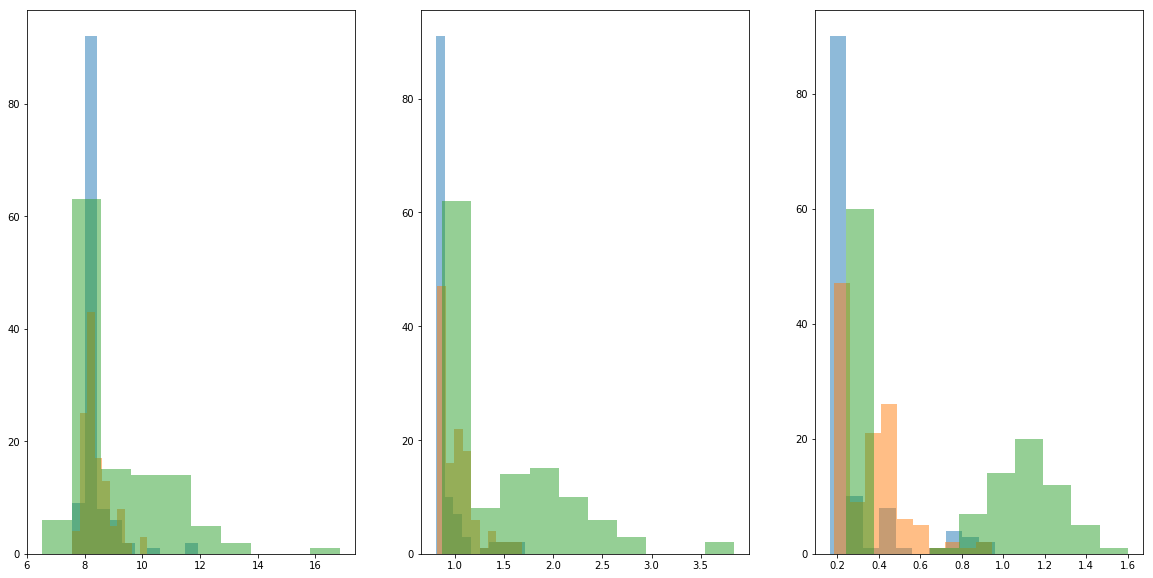

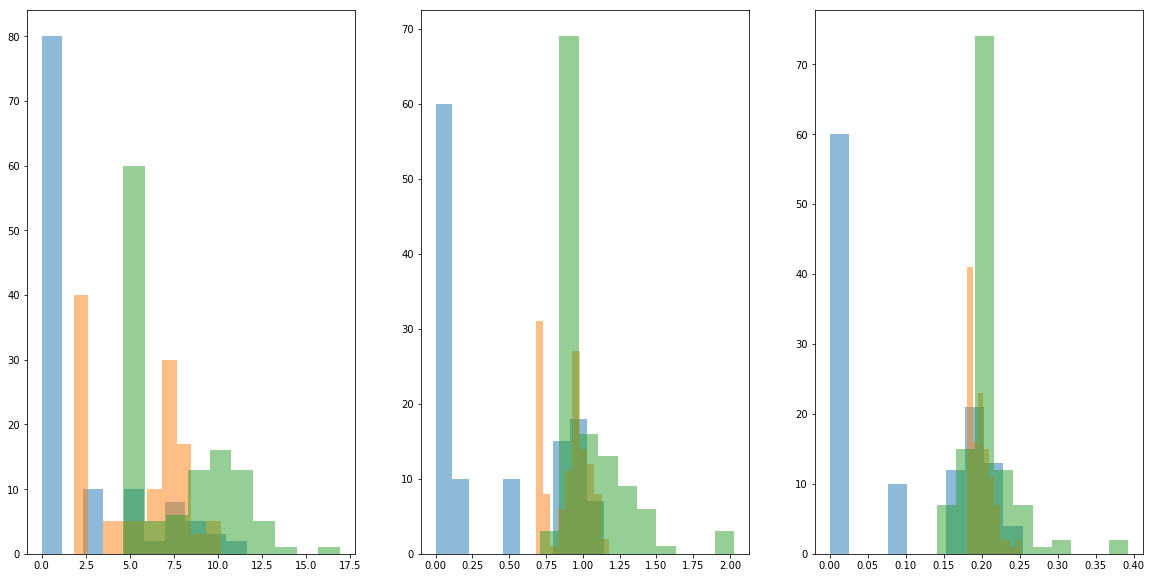

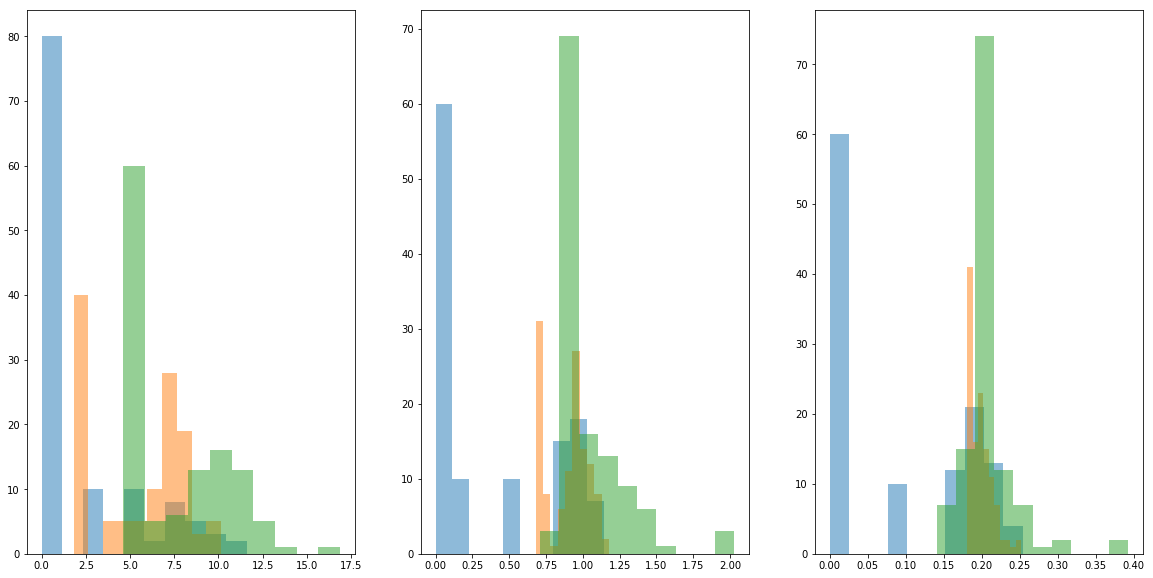

In [22]:
# Plot for each method, a histogram of errors for each sample size, separately coloring the three different
# results for each interpolation coefficient

fig1, ax1 = plt.subplots(1, 3, figsize = (20, 10))
fig2, ax2 = plt.subplots(1, 3, figsize = (20, 10))
fig3, ax3 = plt.subplots(1, 3, figsize = (20, 10))
fig4, ax4 = plt.subplots(1, 3, figsize = (20, 10))

for i in range(3):
    a = ax1[i]
    a.hist(errors[i, :, :, :, :, 0, 0].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 1, 0].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 2, 0].ravel(), alpha = 0.5)
    
for i in range(3):
    a = ax2[i]
    a.hist(errors[i, :, :, :, :, 0, 2].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 1, 2].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 2, 2].ravel(), alpha = 0.5)
    
for i in range(3):
    a = ax3[i]
    a.hist(errors[i, :, :, :, :, 0, 3].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 1, 3].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 2, 3].ravel(), alpha = 0.5)
    
for i in range(3):
    a = ax4[i]
    a.hist(errors[i, :, :, :, :, 0, 4].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 1, 4].ravel(), alpha = 0.5)
    a.hist(errors[i, :, :, :, :, 2, 4].ravel(), alpha = 0.5)

In [23]:
import os

In [24]:
os.pwd()

AttributeError: module 'os' has no attribute 'pwd'

In [25]:
os.pwd

AttributeError: module 'os' has no attribute 'pwd'

In [26]:
os.get_cwd()

AttributeError: module 'os' has no attribute 'get_cwd'

In [27]:
os.listdir('.')

['Untitled1.ipynb',
 'Untitled.ipynb',
 'Postprocess_ExpFalloffCorr.ipynb',
 'Postprocess_2.ipynb',
 'Untitled2.ipynb',
 'Postprocess_01222019c.ipynb',
 'AnalyzeRuntimes.ipynb',
 'Postprocess Exp_Falloff.ipynb',
 'UoIElasticNetBenchmark.ipynb',
 'Postprocess_BlockCorrelations.ipynb',
 'SummaryGraphs.ipynb',
 'Test UoI Hybrid.ipynb',
 'exp1.ipynb',
 'Covariance Scaling.ipynb',
 'TestGTV.ipynb',
 'Untitled3.ipynb',
 'Normalization Issues Example.ipynb',
 'Postprocess Est_Comparison.ipynb',
 'Postprocess_InterpolatedCorr-v2.ipynb',
 'Postprocess-UoIElasticNet.ipynb',
 'UoIEN with l1_ratio 1 included.ipynb',
 'Postprocess_01242019.ipynb',
 'Selection Details.ipynb',
 'Test of Grouping Effect in Supports.ipynb',
 'exp1_test.ipynb',
 'exp2.ipynb',
 'Postprocess_01202019.ipynb',
 'exp4.ipynb',
 'Benchmark UoI ElasticNet.ipynb',
 'IsolateSelectionProblem.ipynb',
 'Postprocess Stability Selection.ipynb',
 'Test Sparse Group Lasso-Copy1.ipynb',
 'exp3.ipynb',
 '.ipynb_checkpoints',
 'Postprocess